In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Homework 8

In this homework, you will be using a form of attention called *attention pooling* to solve the "addition problem". The addition problem was introduced in the [LSTM paper](https://www.bioinf.jku.at/publications/older/2604.pdf) as a way to test whether an RNN could propagate information across many time steps. In the addition problem, the model is given a sequence of 2D vectors in the format:

|     |      |     |     |      |     |      |     |     |     |     |
|-----|------|-----|-----|------|-----|------|-----|-----|-----|-----|
| 0.5 | -0.7 | 0.3 | 0.1 | -0.2 | ... | -0.5 | 0.9 | ... | 0.8 | 0.2 |
| 0   |   0  |  1  |  0  |   0  |     |   0  |  1  |     |  0  |  0  |

The first dimension of each vector in the sequence is a random number between 0 and 1. The second dimension is 0 for all entries of the sequence expect for 2, where it is 1. The goal of the addition problem is to output the sum of the values in the first dimension at the two indices where the second dimension is 1. In the example above, the target would be 0.9 + 0.3 = 1.2. Below is a code snippet which generates a sequence and its target for the addition problem.

In [2]:
import numpy as np

def addition_problem(sequence_length=50):
    output = np.random.uniform(-1, 1, (sequence_length, 2))
    output[:, 0] = 0.
    random_indices = np.random.choice(sequence_length, size=2, replace=False)
    output[random_indices, [0, 0]] = 1
    return output, (output[:, 0]*output[:, 1]).sum(keepdims=True)

Attention pooling is a form of attention that allows a model to solve the addition problem without using an RNN. In attention pooling, the query vector $q$ is a *learnable parameter*. The keys and values are both the input sequence. Specifically, given a sequence $\{h_1, h_2, \ldots, h_T\}$, attention pooling computes
\begin{align}
e_t &= \mathrm{a}(q, h_t) \\
\alpha_t &= \frac{\exp(e_t)}{\sum_k \exp(e_k)} \\
c &= \sum_{t = 1}^T \alpha_t h_t
\end{align}
where $\mathrm{a}(q, h_t)$ is the attention energy function. Note that c will always be a fixed-length vector (which amounts to a weighted average of the elements of the sequence $h$) regardless of how long the sequence is (i.e. the value of $T$). $\mathrm{a}(q, h_t)$ can be any function that takes in a single entry of the sequence $h_t$ and outputs an unnormalizes scalar value. One option is to use
$$\mathrm{a}(q, h_t) = q^\top \tanh(W_a h_t + b_a)$$
where $q \in \mathbb{R}^q$, $W_a \in \mathbb{R}^{q \times d}$, and $b_a \in \mathbb{R}^q$ are learnable parameters, and $d$ is the dimensionality of $h_t$ (i.e. $h_t \in \mathbb{R}^d$).


1. Build and train a neural network that uses attention pooling to solve the addition problem. The model should output a scalar which corresponds to the target value for the addition problem (i.e. the sum of the sequence entries that are marked with a "1"). Here, "solved" means that the squared error of the model's predicitons is always below $0.05$. Use a sequence length of $50$ (which is the default for the `addition_problem` function defined above). *Hints*:
  1. This is a regression problem. Your model should predict a continuous scalar value and you can use a squared-error loss.
  1. The point of the attention pooling layer is to allow you to put it in an otherwise feed-forward network. So, consider just using simple dense feed-forward layers before and/or after the attention pooling layer. To start, you can try the architecture: feed-forward, attention pooling, feed-forward, output layer.
  1. If you are finding that the model is getting stuck at a non-zero squared error, it could be that it's just outputting the mean value and having trouble learning a good solution. Try different initialization, nonlinearities, architecture, learning rate, etc.
1. Once you have trained a model that gets solid performance at sequence length $50$, plot the model's average squared error for sequence lengths $50, 55, 65, 80, 100, 125, 150$. You should generate this plot by averaging the squared error over at least $100$ sequences of a given length. Does the model's error get worse (go up) for longer sequences, or does it generalize to longer sequence lengths?

In [3]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np
import time
import torch

import torch.utils.data as data_utils
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split

import copy
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error

seedy = 666
torch.manual_seed(seedy)
from torch.utils.data import random_split

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [4]:
def train_model(train_loader, val_loader, model, optimizer, batch_size, num_epochs):
    
    train_loss = []
    train_err = []
    val_loss = []
    val_err = []
    
    running = - math.inf
    current = running
    best_run = 0
    best_model = copy.deepcopy(model.state_dict())
    
    for epoch in tqdm(range(num_epochs), total=num_epochs):
        print("Epoch",epoch+1)
        for phase in ['train','validate']:
            running_loss = 0.0
            running_err = 0.0
            if phase=='train':
                loader = train_loader
                model.train()
            else:
                loader = val_loader
                model.eval()
                
            for inputs,labels in loader:  # for inputs,labels in tqdm(loader, total=len(loader)):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()                        
                        optimizer.step()
                running_loss += loss.item()
                y_test = np.asarray(labels.cpu())
                y_pred = outputs.cpu().detach().numpy()
                mse = mean_squared_error(y_test, y_pred)
                err = mse
                running_err += err
            loss = running_loss / len(loader) 
            err =  running_err / len(loader) 
            
            if phase=='train':
                train_err.append(err)
            elif phase=='validate':
                val_err.append(err)
                if err >= running:
                    running = err
                    best_run = epoch+1
                    best_model = copy.deepcopy(model.state_dict()) 
                
            print("~ %s err: %5.3f" % (phase,err))
            if current >= running and phase=='validate':
                print("      BEST SO FAR ^ ^ ^")
        
    return (best_run, best_model, train_loss, train_err, val_loss, val_err)

In [264]:
class SelfAttention(nn.Module):
    def __init__(self, q_dim, bias=True, dropout=0.0):
        super(SelfAttention, self).__init__()
        self.W_a = nn.Linear(q_dim, q_dim, bias=True)
        self.W_q = nn.Linear(q_dim, q_dim, bias=False)
          
    def forward(self, h):
        ## Input (h) is embedding of size (batch_size x len(seq) x 2)        
        _e = torch.tanh( self.W_a(h) )
        e = self.W_q( _e )
        alpha = torch.softmax( e,dim=2 )
        c = torch.sum( alpha*h, axis=1)
        return c

In [302]:
class KatNet(nn.Module):

    def __init__(self, seq_len, drpt=0.00):
        super(KatNet, self).__init__()

        self.mlp_1 = nn.Linear(seq_len*2, seq_len*2)
        self.bn_1 = nn.BatchNorm1d(seq_len*2)
        self.attn = SelfAttention(q_dim=2)
        self.mlp_2 = nn.Linear(2, 2)
        self.bn_2 = nn.BatchNorm1d(2)
        self.out = nn.Linear(2, 1)
        
        self.relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def forward(self, seq):
        x = seq.view(seq.shape[0], -1)
        x = self.mlp_1(x)
        x = self.relu(x) 
        x = self.bn_1(x) 

        x = x.view(seq.shape[0],seq.shape[1],-1)
        x = self.attn(x)
        
        x = self.mlp_2(x)
        x = self.relu(x) 

        x = self.mlp_2(x)

#         x = self.tanh(x)
#         x = self.relu(x) 
#         x = self.bn_2(x) 

        x = self.out(x)

        return x

### Generate some data. Will use 10000 samples. I will do a 1/9 split for test/train.

In [369]:
num_samps = int(100000*1.25)

# # # # # # # #
seq_len = 25
# # # # # # # #

raw = [addition_problem(seq_len) for i in range(num_samps)]
X, y = zip(*raw)
X, y = map(lambda tup: np.array(tup), [X, y])
X, y = map(lambda arr: torch.from_numpy(arr), [X, y])

## Split into test, train, and val sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seedy)
## Make tensor datasets.
_data_train = data_utils.TensorDataset(X_train, y_train)
data_test = data_utils.TensorDataset(X_test, y_test)
print(X_train.shape, X_test.shape)

torch.Size([100000, 25, 2]) torch.Size([25000, 25, 2])


In [371]:
my_batchsize = 1024
my_drpt = 0.01
model = KatNet(seq_len, my_drpt).to(device).double() ## Need to raise to double. Stupid pytorch.

num_val = int(len(_data_train)*0.1)
num_train = len(_data_train) - num_val
data_train, data_val = random_split(_data_train, [num_train, num_val])

loader_train = data_utils.DataLoader(data_train, my_batchsize, shuffle=True)
loader_val = data_utils.DataLoader(data_val, my_batchsize)

print(num_train,num_val)

my_epochs = 64
my_lr = 0.001

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=my_lr)

s = time.time()
br,bm,tl,ta,vl,va = train_model(loader_train,loader_val,model,optimizer,my_batchsize,my_epochs)
e = time.time()

90000 10000


Epoch 1
~ train err: 0.667
~ validate err: 0.581
Epoch 2
~ train err: 0.491
~ validate err: 0.393
Epoch 3
~ train err: 0.283
~ validate err: 0.209
Epoch 4
~ train err: 0.156
~ validate err: 0.123
Epoch 5
~ train err: 0.099
~ validate err: 0.082
Epoch 6
~ train err: 0.071
~ validate err: 0.062
Epoch 7
~ train err: 0.057
~ validate err: 0.050
Epoch 8
~ train err: 0.047
~ validate err: 0.043
Epoch 9
~ train err: 0.041
~ validate err: 0.036
Epoch 10
~ train err: 0.036
~ validate err: 0.031
Epoch 11
~ train err: 0.033
~ validate err: 0.028
Epoch 12
~ train err: 0.029
~ validate err: 0.024
Epoch 13
~ train err: 0.028
~ validate err: 0.022
Epoch 14
~ train err: 0.026
~ validate err: 0.020
Epoch 15
~ train err: 0.024
~ validate err: 0.019
Epoch 16
~ train err: 0.023
~ validate err: 0.017
Epoch 17
~ train err: 0.023
~ validate err: 0.017
Epoch 18
~ train err: 0.021
~ validate err: 0.016
Epoch 19
~ train err: 0.020
~ validate err: 0.016
Epoch 20
~ train err: 0.020
~ validate err: 0.015
Epoch 21


In [372]:
print("%5.3f mins" % ((e-s)/60))

1.561 mins


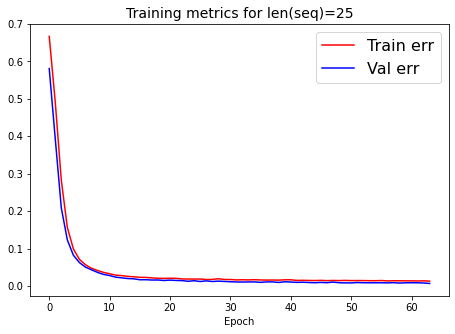

In [373]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(7.5,5))
plt.plot(ta,label='Train err',c='red')
plt.plot(va,label='Val err',c='blue')
plt.xlabel("Epoch")
plt.legend(loc='upper right',fontsize=16)
plt.title("Training metrics for len(seq)=%d" % seq_len,fontsize=14)
plt.savefig("hw8_mse_len%d" % seq_len)

plt.show()

In [374]:
def eval_model(model, loader):
    model.eval()
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_test = np.asarray(labels.cpu())
        y_pred = outputs.cpu().detach().numpy()
        mse = mean_squared_error(y_test, y_pred)
        return y_test,y_pred,mse

In [375]:
my_batchsize = 1000
loader_test = data_utils.DataLoader(data_test, my_batchsize, shuffle=True)
res_y_test,res_y_pred,res_mse = eval_model(model, loader_test)

In [376]:
print(res_mse)

0.006737692710837154


In [377]:
res_mse

0.006737692710837154

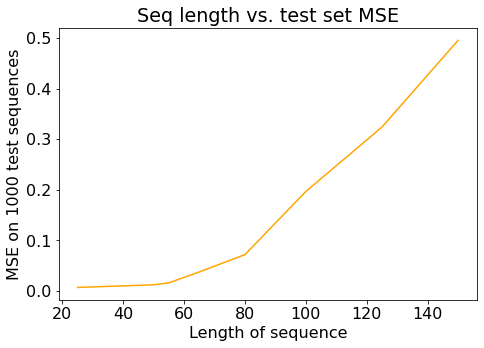

In [378]:
x = [25, 50, 55, 65, 80, 100, 125, 150]
y = [0.006737692710837154, 0.01199094563714196, 0.01588235919823697, 0.03743441403874655, 0.07175528446551482, 0.19674573123791192,
    0.32403050343116196, 0.4957209874437373]

plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(7.5,5))
plt.plot(x,y,c='orange')
plt.xlabel("Length of sequence")
plt.ylabel("MSE on 1000 test sequences")

plt.title("Seq length vs. test set MSE")
plt.savefig("hw8_lengths_small")

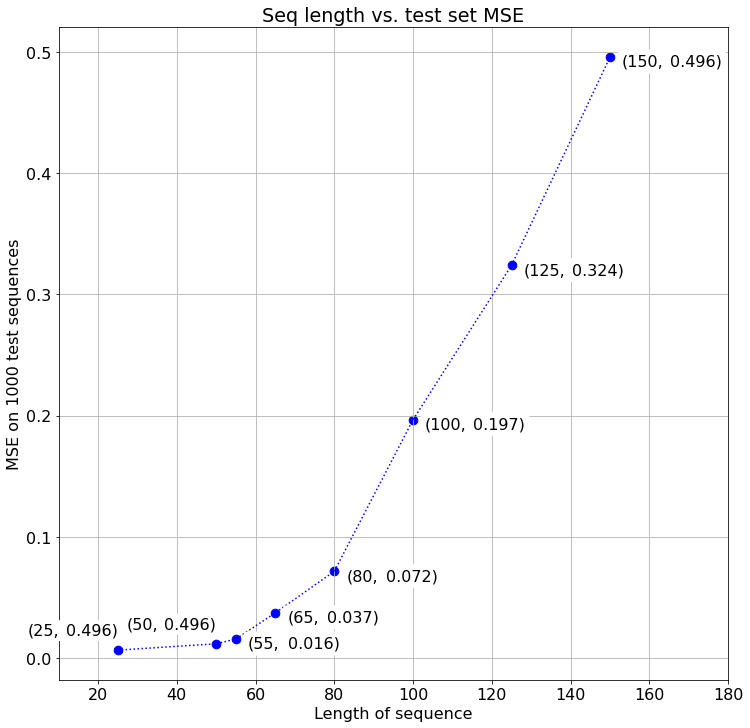

In [406]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

plt.plot(x,y,"b:")
plt.scatter(x, y, s=75, c="b")
plt.xlim(10,180)

for it,(i,j) in enumerate(zip(x,y)):
    if it<=1:
        ax.annotate('%s)' %_j, xy=(i,j), xytext=(-52,15), textcoords='offset points', bbox=my_box)
        ax.annotate('(%s,' %i, xy=(i,j), xytext=(-90,15), textcoords='offset points', bbox=my_box)
        continue
    _j = round(j,3)
    
    my_box = dict(facecolor='white', edgecolor='white', boxstyle='round,pad=.25')
    if i>=100:
        off = 60
    else:
        off = 52
    ax.annotate('%s)' %_j, xy=(i,j), xytext=(off,-9), textcoords='offset points', bbox=my_box)
    ax.annotate('(%s,' %i, xy=(i,j), xytext=(12,-9), textcoords='offset points', bbox=my_box)

plt.xlabel("Length of sequence")
plt.ylabel("MSE on 1000 test sequences")

plt.title("Seq length vs. test set MSE")
plt.grid()
plt.savefig("hw8_lengths")


plt.show()